In [5]:
import os
import json
import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

# Unzip NASLib/run/results/correlation_13proxies_all_benchmarks.zip before running the code


In [21]:
BENCHMARKS = {
    'nasbench101': ['cifar10'],
    'nasbench201': ['cifar10', 'cifar100', 'ImageNet16-120'],
    'nasbench301': ['cifar10'],
    'transbench101_micro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic'],
    'transbench101_macro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic']
}

LABELS = {
    'nasbench101': 'NB101',
    'nasbench201': 'NB201',
    'nasbench301': 'NB301',
    'transbench101_micro': 'TNB101_MICRO',
    'transbench101_macro': 'TNB101_MACRO',
    'cifar10': 'CF10',
    'cifar100': 'CF100',
    'ImageNet16-120': 'IMGNT',
    'jigsaw': 'JIGSAW',
    'class_scene': 'SCENE',
    'class_object': 'OBJECT',
    'autoencoder': 'AUTOENC',
    'normal': 'NORMAL',
    'room_layout': 'ROOM',
    'segmentsemantic': 'SEGMENT',
}

START_SEED=9000
END_SEED=9010

TEST_SIZE=1000

def get_all_files(root_folder='../run/results/correlation_13proxies_all_benchmarks/correlation', filename='scores.json'):
    all_files = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(filename):
                #print(os.path.join(root, file))
                all_files.append(os.path.join(root, file))

    return all_files

def get_scores_as_nested_dict(files):

    data = {}

    for file in files:
        file_components = file.split('/')
        search_space, dataset, predictor, seed = file_components[-5], file_components[-4], file_components[-3], file_components[-2]

        with open(file, 'r') as f:
            scores = json.load(f)[1]

        if search_space not in data:
            data[search_space] = {}
        if dataset not in data[search_space]:
            data[search_space][dataset] = {}
        if predictor not in data[search_space][dataset]:
            data[search_space][dataset][predictor] = {
                'kendalltau': [],
                'pearson': [],
                'spearman': []
            }
            

        data[search_space][dataset][predictor]['kendalltau'].append(scores['kendalltau'])
        data[search_space][dataset][predictor]['pearson'].append(scores['pearson'])
        data[search_space][dataset][predictor]['spearman'].append(scores['spearman'])
    
    return data

def get_scores_as_list_of_dict(files):
    data = []

    for file in files:
        file_components = file.split('/')
        search_space, dataset, predictor, seed = file_components[-5], file_components[-4], file_components[-3], file_components[-2]
        
        with open(file, 'r') as f:
            scores = json.load(f)[1]

        record = {
            'search_space': search_space,
            'dataset': dataset,
            'predictor': predictor,
            'seed': seed,
            'kendalltau': scores['kendalltau'],
            'pearson': scores['pearson'],
            'spearman': scores['spearman'],
            'preds': scores['full_testpred'],
            'ground_truth': scores['full_ytest'],
        }

        data.append(record)

    return data

def sort_by_mean(df):
    df = df.reindex(df.transpose().mean().sort_values().index)
    df = df.reindex(df.mean().sort_values().index, axis=1)
    return df

def plot_heatmap(df, figsize=(20, 10), rotation=0, title='', cmap='viridis_r', savetitle='zcp_corr', savedir='.'):
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    heatmap = sns.heatmap(df, annot=True, cmap=cmap, fmt='.2f', vmin=-1, vmax=1, cbar=False)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=rotation, fontsize=12)
    heatmap.set(xlabel=None)
    heatmap.set(ylabel=None)
    plt.tight_layout()
    if savedir != '.':
        os.makedirs(savedir, exist_ok=True)
    plt.savefig('{}/{}.pdf'.format(savedir, savetitle), bbox_inches='tight')    

def plot_heatmap_for_benchmark(df, search_space, dataset, corr_type):
    _df = df[(df['search_space'] == search_space) & (df['dataset'] == dataset)][['predictor', 'seed', corr_type]]

#     print('BEFORE PIVOT')
#     print(_df)
#     print('___')
    
    pivot_df = _df.pivot_table(corr_type, 'seed', 'predictor')
    
#     print('PIVOT TABLE')
#     print(pivot_df)
#     print('___')

    plot_heatmap(pivot_df.corr(), title=f'Correlation between rank correlations for {search_space}-{dataset}')

def compute_correlation(df, predictors):
    corr = np.zeros((len(predictors), len(predictors)))
    for i in range(len(predictors)):
        for j in range(len(predictors)):
            zc_1 = predictors[i]
            zc_2 = predictors[j]

            preds_1 = np.array(df[df['predictor'] == zc_1]['preds'].to_list()[0])
            preds_2 = np.array(df[df['predictor'] == zc_2]['preds'].to_list()[0])
            
            try:
                if len(preds_1) != len(preds_2):
                    print(zc_1, zc_2, len(zc_1), len(zc_2), 'prediction sizes do not match')
                    continue
            except:
                print(zc_1, preds_1)
                print(zc_2, preds_2)
                
            coeff = np.corrcoef(preds_1, preds_2)[0, 1]
                
            #print(preds_1.shape, preds_2.shape, coeff)
            corr[i, j] = coeff

    return corr

def plot_correlation_between_zcs(df, search_space, dataset):
    all_corrs = []
    for seed in [str(i) for i in range(START_SEED, END_SEED)]:
    
#         print(f'Computing correlation for {search_space} {dataset} {seed}')
        df_ = df[(df['search_space'] == search_space) & (df['seed'] == seed) & (df['dataset'] == dataset)]
        
#         print(df_)
        predictors = tuple(set(df_['predictor'].to_list())) # List of predictor names
#         print('Predictors used to compute correlation: ', predictors)
        correlation = compute_correlation(df_, predictors)
#         print('correlation shape', correlation.shape)
        all_corrs.append(correlation)

#     print('all_corrs ::', np.array(all_corrs))
    corr = np.mean(np.array(all_corrs), axis=0)
#     print('mean corrs ::', corr.shape)
    corr_df = pd.DataFrame(corr)

    predictors_map = {i: predictors[i] for i in range(len(predictors))}
    corr_df = corr_df.rename(columns=predictors_map, index=predictors_map)
    corr_df = sort_by_mean(corr_df)
    plot_heatmap(corr_df, title=f'{search_space}-{dataset}', figsize=(10,8),
                 savedir='correlation_between_zcs', savetitle=f'{search_space}-{dataset}')
    
def show_seeds(df, search_space):
    return df[df['search_space'] == search_space].groupby(['search_space', 'dataset', 'predictor'])['seed'].agg(['unique'])

def make_df(files):
    data = get_scores_as_list_of_dict(files)
    df = pd.DataFrame(data)
    return df

def make_search_space_predictors_df(df, metric, benchmarks):
    pred_scores = df.groupby(['search_space', 'dataset', 'predictor'])[metric].mean()
    
#     print('pred scores')
#     print(pred_scores)
    
    series = []
    for searchspace, datasets in benchmarks.items():
        for dataset in datasets:
            #print(searchspace, dataset)
            if searchspace in pred_scores and dataset in pred_scores[searchspace]:
                series.append(pred_scores[searchspace][dataset].rename(f'{LABELS[searchspace]}-{LABELS[dataset]}'))

#     print('SERIES')
#     print(series[0])

    # Concatenate all the series from left to right to get the dataframe
    # with datasets as the columns and 
    idf = series[0].to_frame()

    for idx, s in enumerate(series):
        if idx == 0:
            continue

        idf = idf.merge(s.to_frame(), left_index=True, right_index=True)

    return idf

def count_nans(df, col):
    n_wrong = 0
    wrong_ones = []
    indices = []

    for idx, p in enumerate(list(df['preds'])):
        if len(p) != 200:
            n_wrong += 1
            wrong_ones.append(len(p))
            indices.append(idx)

    return n_wrong, wrong_ones, indices

def clean_df(df):
#     print(df[df['ground_truth'].isna()])
    df = df.dropna(axis=0, subset=['ground_truth'])
    return df

#with open('../run/correlation/nasbench201/cifar10/jacov/9001/scores.json', 'r') as f:
#    data = json.load(f)

def create_clean_df(preds_to_drop=None):
    files = get_all_files()
    df = make_df(files)
    df = clean_df(df)

    _, _, indices = count_nans(df, 'preds')
    
    df.drop(index=indices)

    if preds_to_drop is not None:
        for predictor in preds_to_drop:
            df = df[df['predictor'] != predictor]
    
    return df

def filter_df(df, search_space, dataset, seed):
    return df[
        (df['search_space'] == search_space) &
        (df['dataset'] == dataset) &
        (df['seed'] == seed)
    ]

def make_clean_df(preds_to_drop=None):
    files = get_all_files()
    df = make_df(files)

    wrong_len_indexes = []
    wrong_type_indexes = []
    all_preds_same_indexes = []
    minus_100_indexes = []

    if preds_to_drop is not None:
        for predictor in preds_to_drop:
            df = df[df['predictor'] != predictor]
    
    for idx in df.index:
        preds = df.loc[idx]['preds']
        if not isinstance(preds, list):
            wrong_type_indexes.append(idx)
        elif len(preds) != TEST_SIZE:
            wrong_len_indexes.append(idx)
#         elif len(set(preds)) == 1:
#             all_preds_same_indexes.append(idx)
#         elif -100000000.0 in preds:
#             minus_100_indexes.append(idx)

    wrong_len_indexes, wrong_type_indexes, len(all_preds_same_indexes), len(minus_100_indexes)
    bad_indices = wrong_len_indexes + wrong_type_indexes + all_preds_same_indexes

    print(df.loc[wrong_type_indexes])
    df = df.drop(index=bad_indices)
    return df


In [11]:
df = make_clean_df()

df['pearson'] = df['pearson'].fillna(0)
df['spearman'] = df['spearman'].fillna(0)
df['kendalltau'] = df['kendalltau'].fillna(0)

df

Empty DataFrame
Columns: [dataset, ground_truth, kendalltau, pearson, predictor, preds, search_space, seed, spearman]
Index: []


,dataset,ground_truth,kendalltau,pearson,predictor,preds,search_space,seed,spearman
0,class_object,"[35.867835998535156, 43.38674545288086, 42.525...",0.290765,0.542478,params,"[9.459588, 7.9113, 6.54298, 15.584132, 23.2569...",transbench101_micro,9009,0.442621
1,class_object,"[39.97810745239258, 35.60409927368164, 41.7844...",0.296211,0.506697,params,"[15.410308, 1.96058, 15.410308, 12.319876, 9.1...",transbench101_micro,9001,0.447774
2,class_object,"[43.46636199951172, 43.38674545288086, 42.8144...",0.321715,0.529932,params,"[17.13242, 8.265092, 14.719108, 9.459588, 7.91...",transbench101_micro,9000,0.479434
3,class_object,"[41.336585998535156, 42.91401290893555, 42.565...",0.302285,0.521321,params,"[15.410308, 8.594564, 6.369156, 9.113732, 14.0...",transbench101_micro,9005,0.457783
4,class_object,"[40.022891998291016, 26.547571182250977, 42.16...",0.292453,0.500670,params,"[9.113732, 15.416452, 26.97434, 9.625476, 1.10...",transbench101_micro,9002,0.436079
5,class_object,"[38.783836364746094, 25.975318908691406, 26.28...",0.293540,0.537254,params,"[16.101508, 1.612932, 9.285764, 8.091268, 9.27...",transbench101_micro,9008,0.441763
6,class_object,"[42.864253997802734, 42.7348747253418, 34.9422...",0.278424,0.515631,params,"[13.176964, 22.399876, 9.805444, 7.74362, 1.10...",transbench101_micro,9006,0.427609
7,class_object,"[44.04856872558594, 42.2720947265625, 30.94645...",0.314688,0.535092,params,"[7.9113, 8.257156, 6.54298, 0.59226, 15.410308...",transbench101_micro,9003,0.469976
8,class_object,"[40.42595672607422, 41.421180725097656, 40.510...",0.298538,0.499304,params,"[16.786564, 16.275332, 17.643652, 1.275524, 16...",transbench101_micro,9004,0.445099
9,class_object,"[42.247215270996094, 42.65525436401367, 43.093...",0.322440,0.550246,params,"[12.4937, 9.459588, 7.565444, 9.113732, 22.399...",transbench101_micro,9007,0.482742


In [7]:
# Uncomment for plots showing correlation between zcs for each benchmark

# for search_space in BENCHMARKS.keys():
#     for dataset in BENCHMARKS[search_space]:
#         plot_correlation_between_zcs(df, search_space, dataset)

In [53]:
def plot_heatmap2(df, figsize=(20, 10), rotation=0, title='', cmap='viridis_r', savetitle='zcp_corr', horizontal_align='right', cbar=True, square=False):
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    heatmap = sns.heatmap(df, annot=True, cmap=cmap, fmt='.2f', cbar=False, square=square)
    for tick in heatmap.get_xticklabels():
        tick.set_fontname("monospace")
    for tick in heatmap.get_yticklabels():
        tick.set_fontname("monospace")
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=rotation, fontsize=12, horizontalalignment=horizontal_align)
    heatmap.set(xlabel=None)
    heatmap.set(ylabel=None)
    plt.tight_layout()
    plt.savefig('{}.pdf'.format(savetitle), bbox_inches='tight')

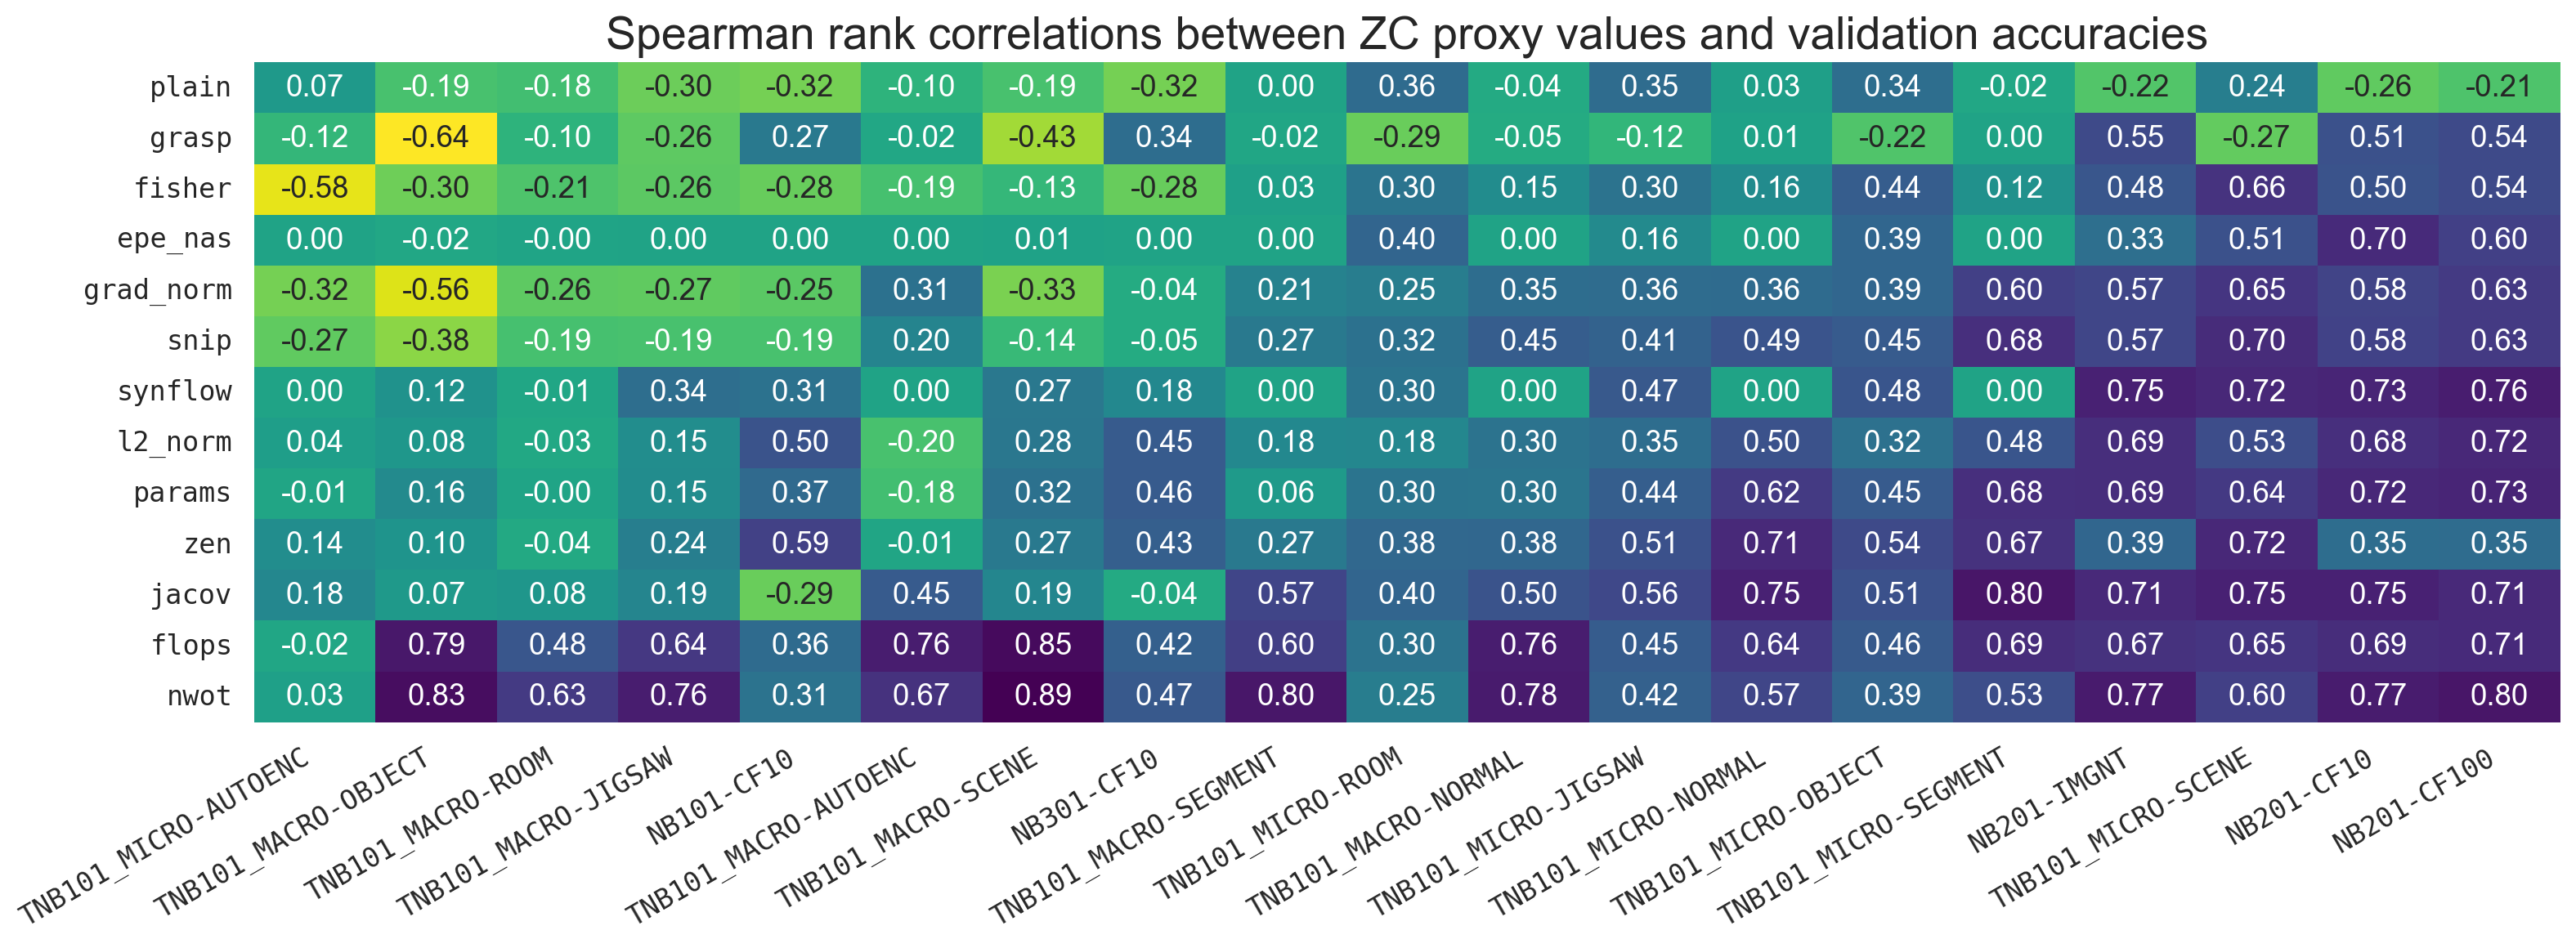

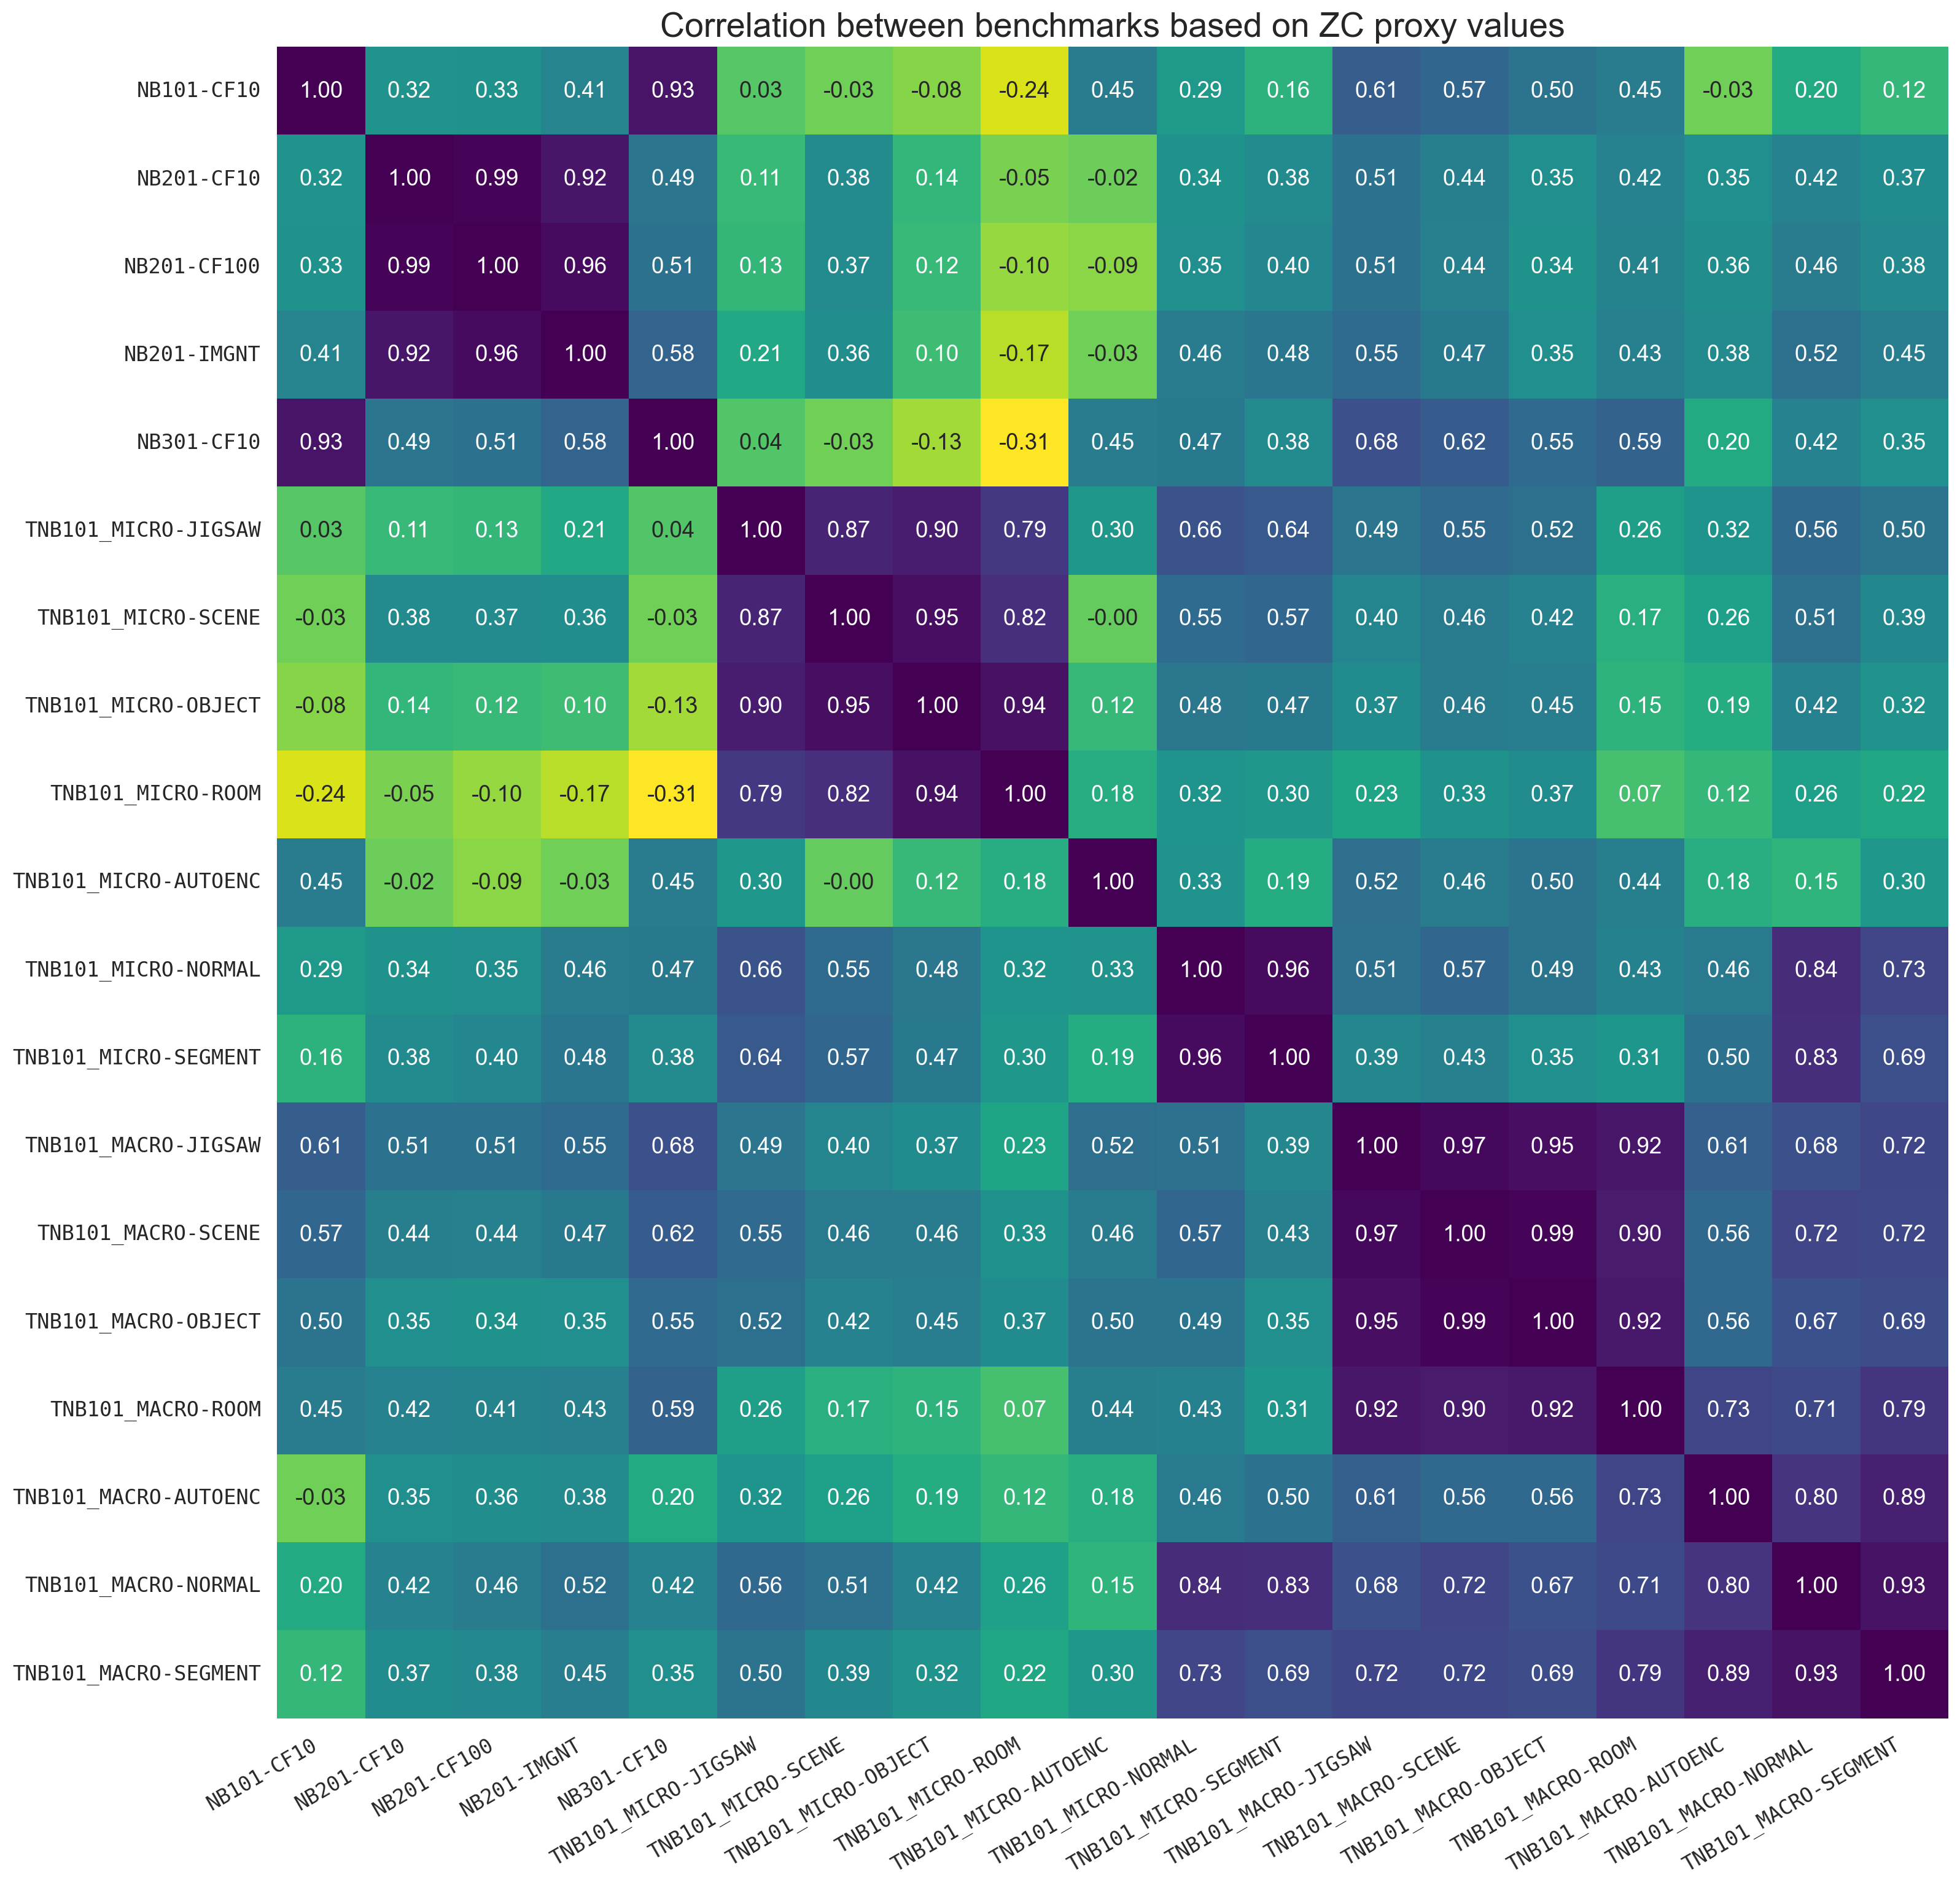

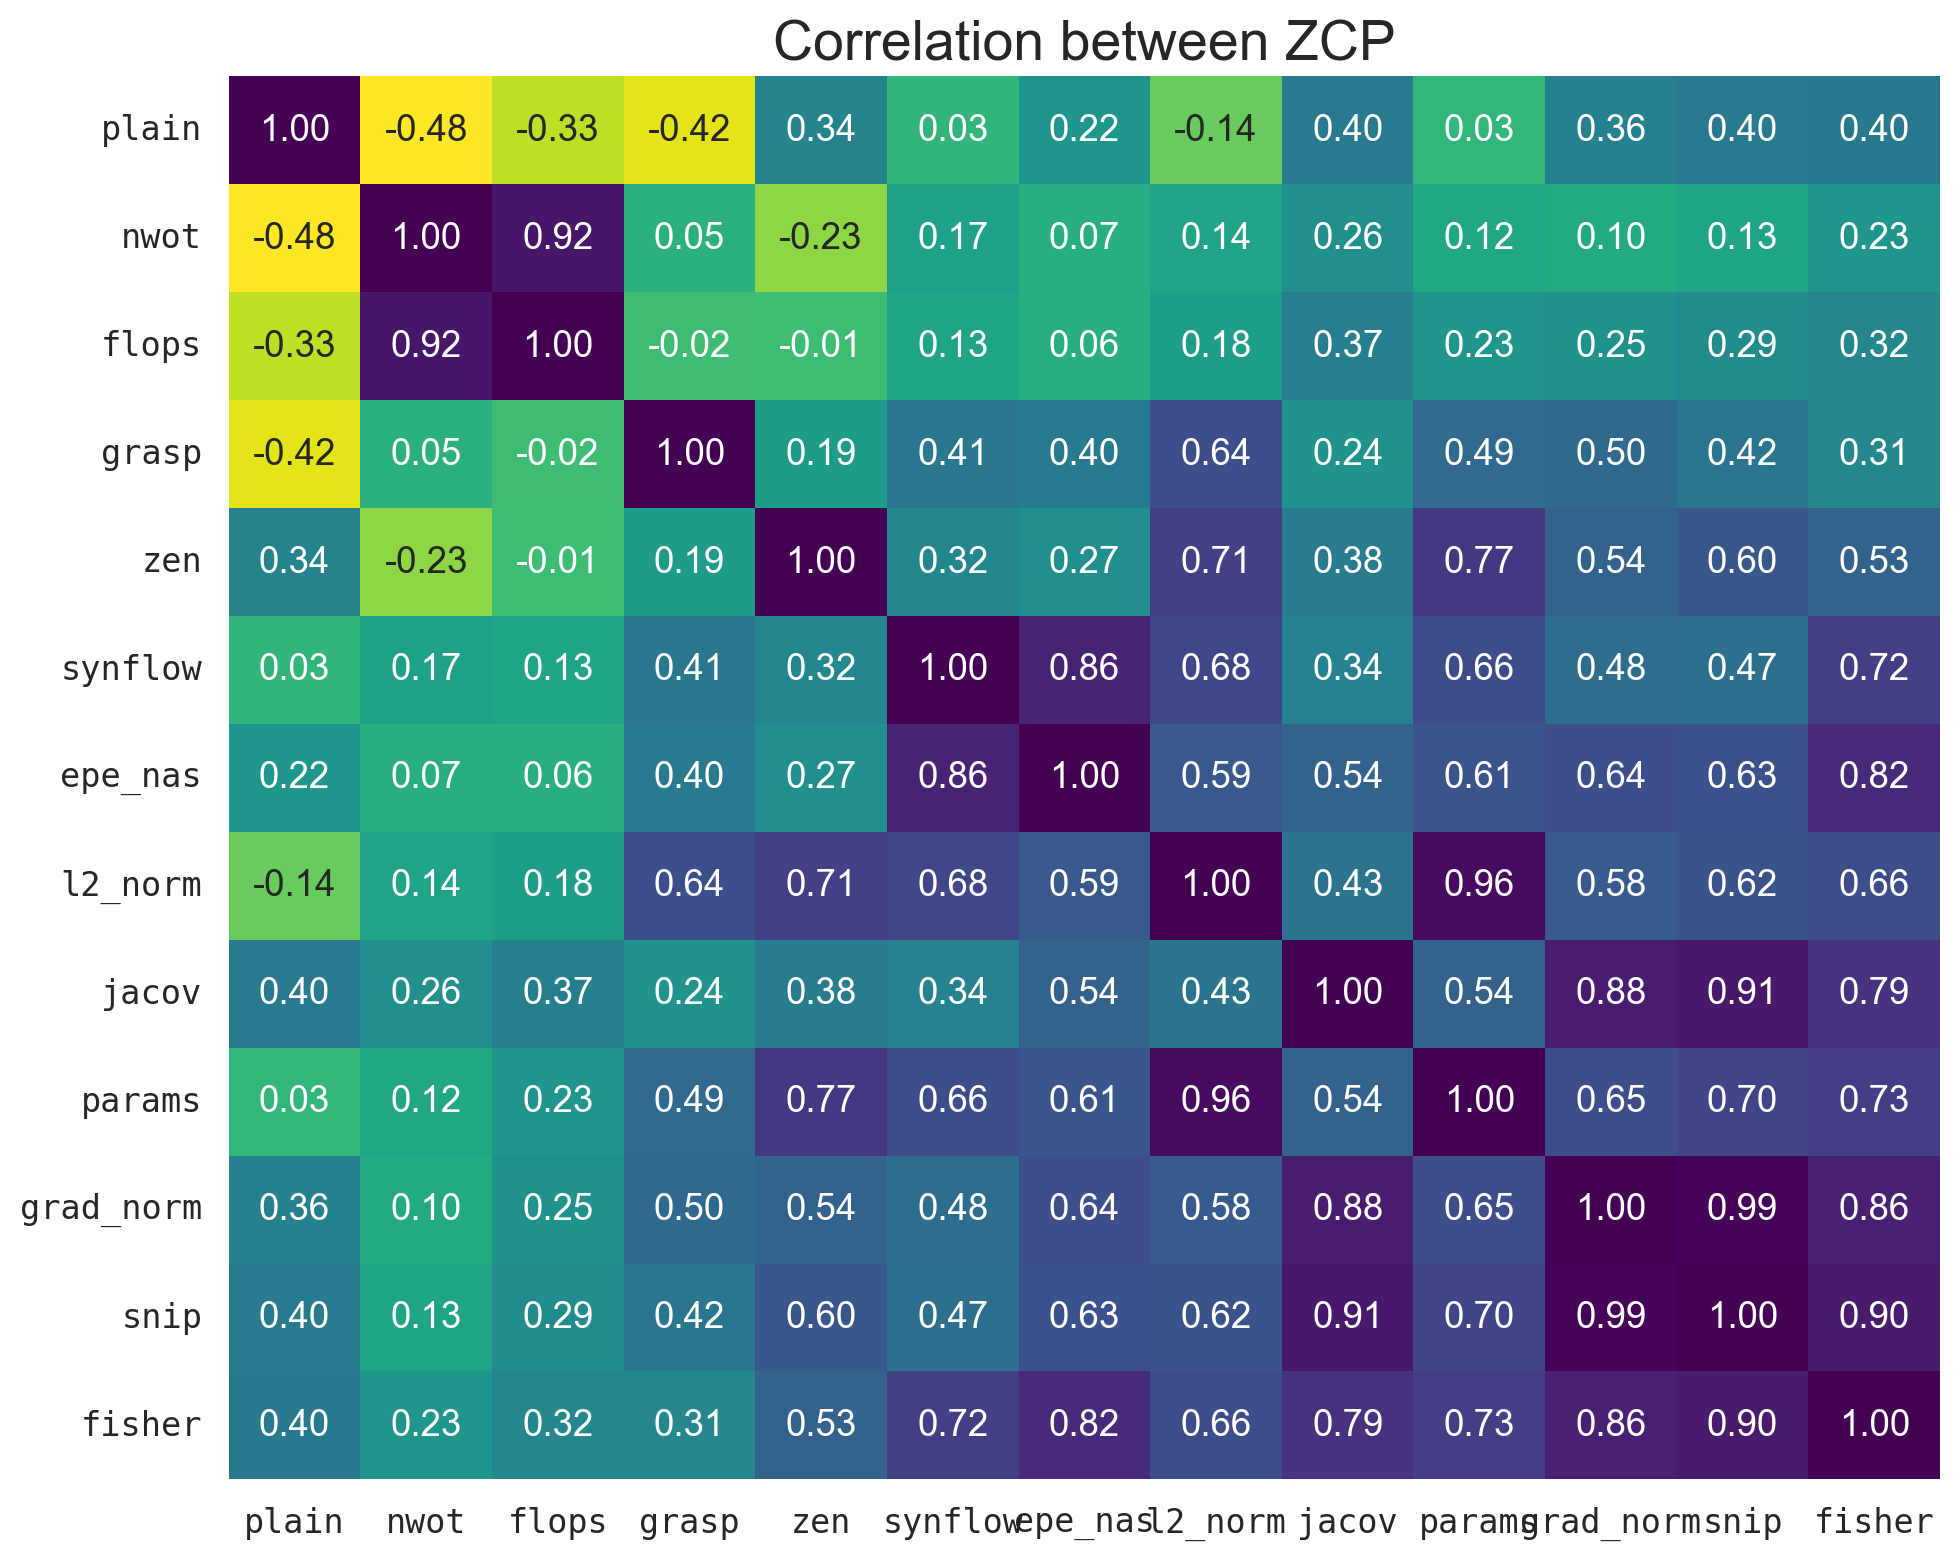

In [54]:
sns.set(font_scale=1.1)
order = ['NB101-CF10', 'NB201-CF10', 'NB201-CF100', 'NB201-IMGNT', 'NB301-CF10',
       'TNB101_MICRO-JIGSAW', 'TNB101_MICRO-SCENE', 'TNB101_MICRO-OBJECT',
       'TNB101_MICRO-ROOM', 'TNB101_MICRO-AUTOENC', 'TNB101_MICRO-NORMAL', 
       'TNB101_MICRO-SEGMENT', 'TNB101_MACRO-JIGSAW', 'TNB101_MACRO-SCENE',
       'TNB101_MACRO-OBJECT', 'TNB101_MACRO-ROOM', 'TNB101_MACRO-AUTOENC',
       'TNB101_MACRO-NORMAL', 'TNB101_MACRO-SEGMENT']

pred_df = make_search_space_predictors_df(df, 'spearman', BENCHMARKS)
pred_df1 = sort_by_mean(pred_df)
plot_heatmap2(pred_df1, figsize=(16, 6), rotation=30,
             title='Spearman rank correlations between ZC proxy values and validation accuracies')

pred_df_bench = pred_df.corr()
pred_df_bench = pred_df_bench.reindex(columns=order, index=order)

# pred_df_bench = sort_by_mean(pred_df_bench)
plot_heatmap2(pred_df_bench, figsize=(16, 16), rotation=30, savetitle='bench_xcorr',
             title='Correlation between benchmarks based on ZC proxy values', cbar=False, square=True)

pred_df_corr = pred_df.transpose().corr()
pred_df_corr = sort_by_mean(pred_df_corr)
plot_heatmap2(pred_df_corr, figsize=(10, 8), rotation=0, savetitle='zcp_xcorr',
             title='Correlation between ZCP', horizontal_align='center')

# plot_heatmap_for_benchmark(df, 'nasbench201', 'cifar10', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench201', 'cifar100', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench201', 'ImageNet16-120', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench301', 'cifar10', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench101', 'cifar10', 'spearman')
# plot_heatmap_for_benchmark(df, 'transbench101_micro', 'jigsaw', 'spearman')
# pred_df

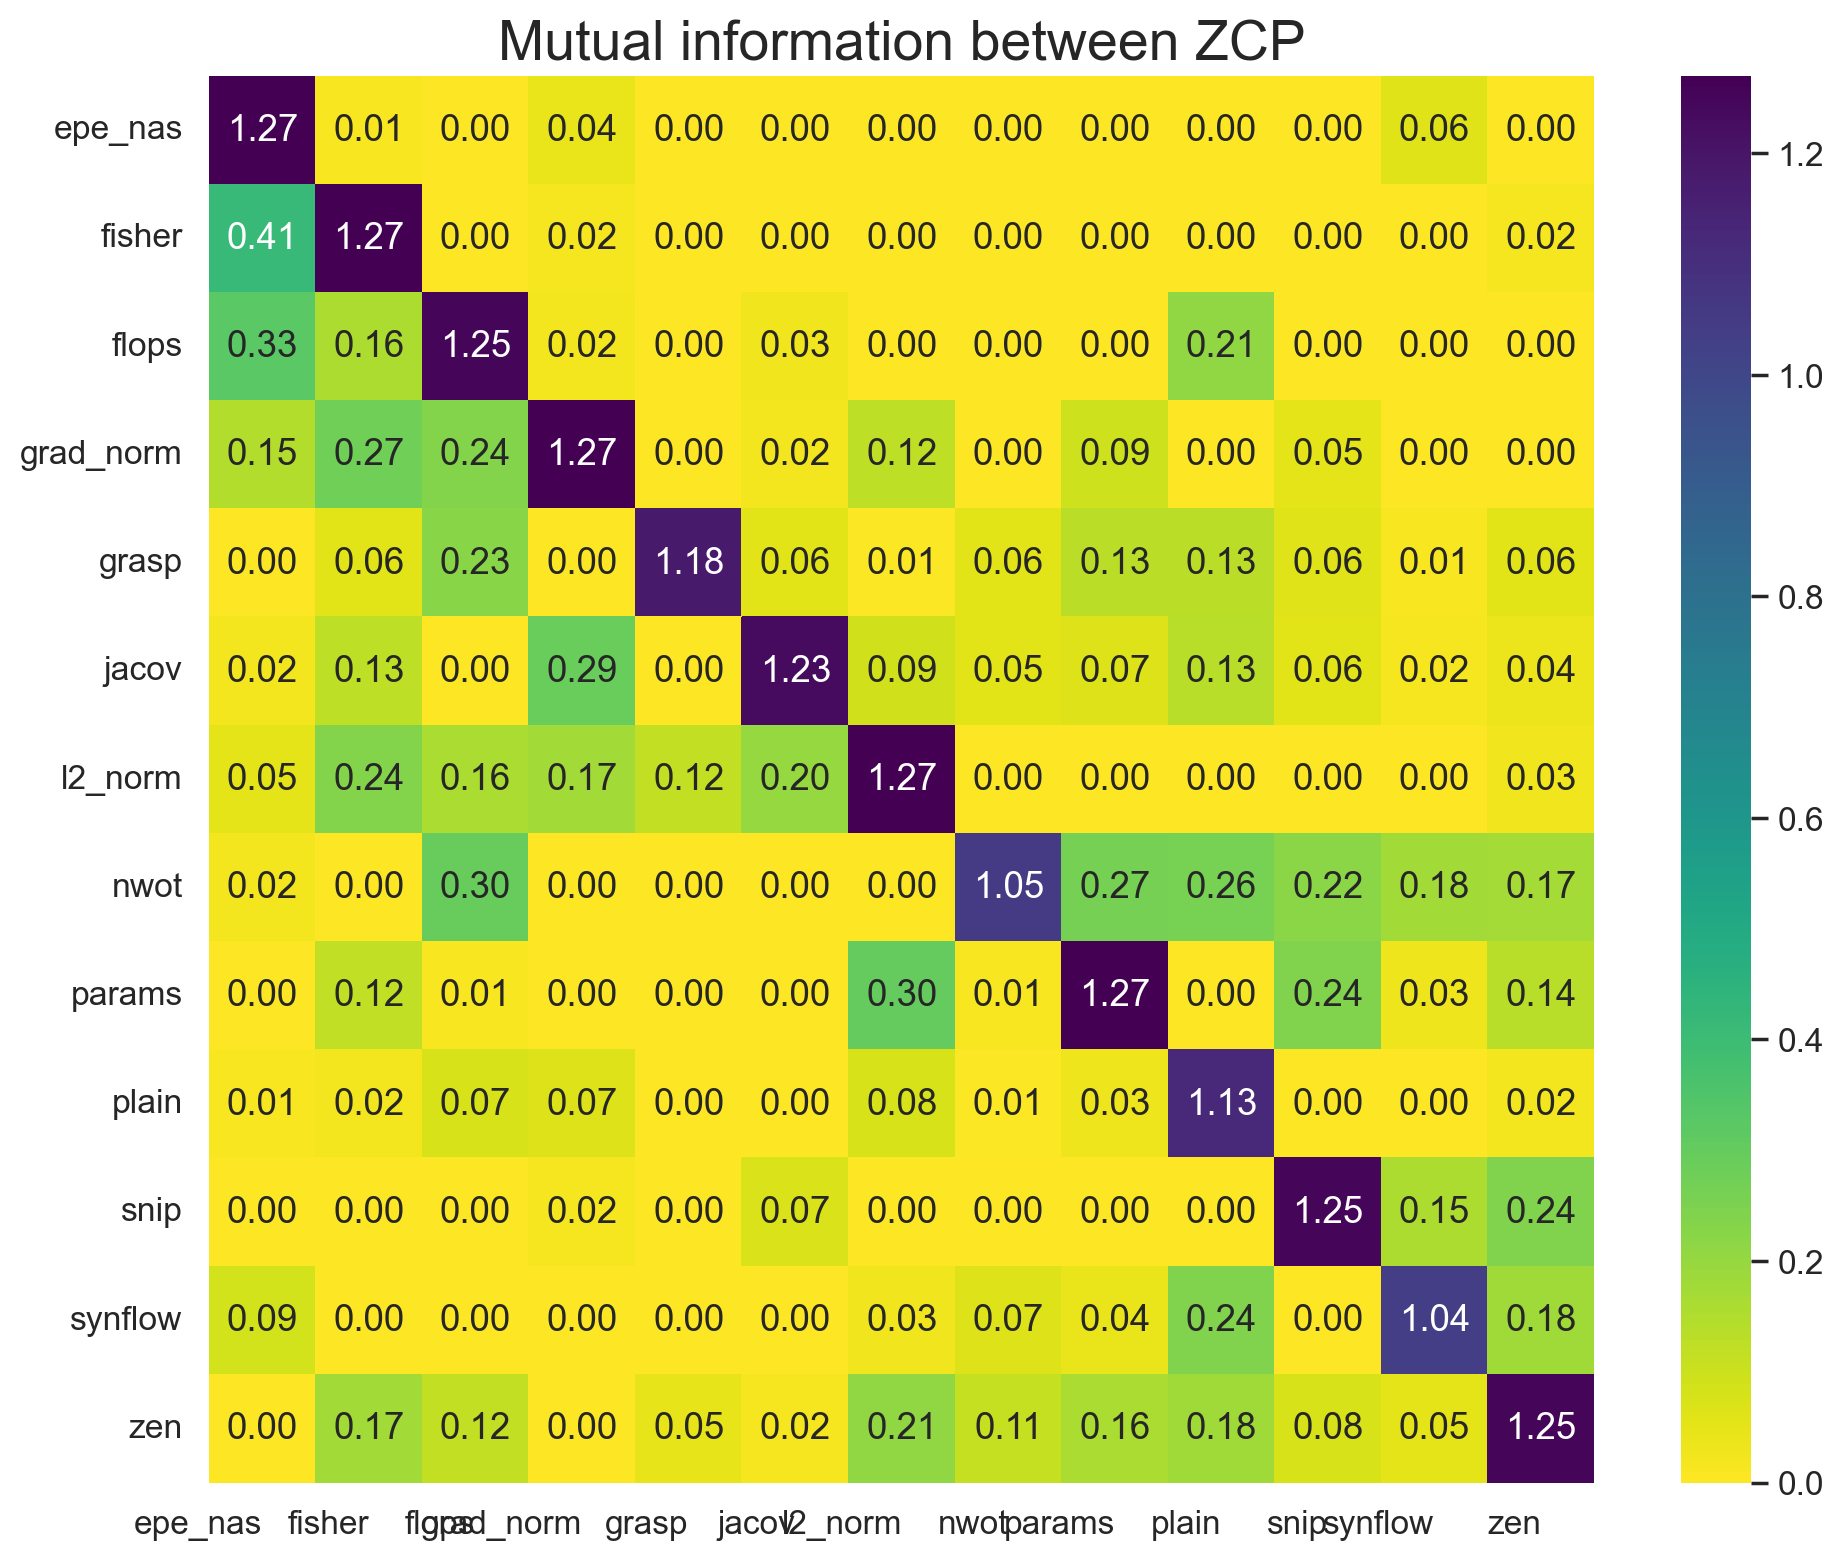

In [10]:
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.feature_selection import mutual_info_regression

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_regression(x.to_numpy().reshape(-1, 1), y.to_numpy())
    #mi = mutual_info_score(None, None, contingency=c_xy)
    return mi, c_xy

pred_df_corr = pred_df.transpose().corr()

for i in pred_df_corr.columns:
    for j in pred_df_corr.columns:
        mi, _ = calc_MI(pred_df_corr[i], pred_df_corr[j], 10)
        pred_df_corr[i][j] = mi
        
#pred_df_corr = sort_by_mean(pred_df_corr)
plot_heatmap2(pred_df_corr, figsize=(10, 8), rotation=0, savetitle='zcp_mutual_inf',
             title='Mutual information between ZCP')